In [1]:
from tqdm.auto import tqdm
import torch 
from transformers import DistilBertModel
from transformers import DistilBertTokenizer
from transformers import PreTrainedTokenizer
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from torch.nn import CosineEmbeddingLoss
#Build up to SBERT model 

/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
deviceNum = 1
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")


In [3]:
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [4]:
#taken almost directly from: 
#https://www.pinecone.io/learn/train-sentence-transformers-softmax/

In [5]:
#clear up memory 

#torch.manual_seed(0)

In [6]:
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2']].dropna()

#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = 1 - ((leanDf["ground_truth"] - 1) / 3)


In [7]:
import re
def getTopSentences(inStr):
    print(re.split("[.!]", inStr))
testStr = leanDf.loc[0,"text2"]
#print(testStr)
getTopSentences(testStr)

['PORT-AU-PRINCE, Haiti — Haitian President Jovenel Moïse broke with tradition on Wednesday and celebrated the country’s independence day in the capital for security reasons following months of political turmoil', '\n\nMoïse, whose government has been accused of corruption, denounced graft during his speech at the National Palace in Port-au-Prince and urged Haiti’s elite to work with the government and help create employment', '\n\n“We’re still extremely poor,” he said', ' “Those who continue to get rich find it normal that they do not pay taxes, find it normal that there can be no competition, find it normal that they set prices for consumers, especially when this consumer is the state itself', '”\n\nMoïse also apologized for the country’s ongoing power outages and renewed his 2016 campaign pledge to provide electricity 24 hours a day, saying it was harder to accomplish than he imagined', '\n\nThe speech that marked the 216th anniversary of the world’s first black republic was origina

In [8]:
#get data loaded in properly 
dataset = Dataset.from_pandas(leanDf)

In [9]:
#link: https://huggingface.co/sentence-transformers/all-mpnet-base-v2
#example of tokenizing 
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
example = dataset[0]["text1"]
first = tokenizer(example)

In [10]:
all_cols = ["ground_truth"]

for part in ["text1", "text2"]: 
    #tokenizes each row of the dataset and gives us back tuple of lists 
    dataset=dataset.map(lambda x: tokenizer(x[part], max_length=384, padding="max_length", truncation=True))
    
    for col in ['input_ids', 'attention_mask']: 
        dataset = dataset.rename_column(
            col, part+'_'+col
        )
        all_cols.append(part+'_'+col)

  0%|          | 0/1676 [00:00<?, ?ex/s]

  0%|          | 0/1676 [00:00<?, ?ex/s]

In [11]:
all_cols

['ground_truth',
 'text1_input_ids',
 'text1_attention_mask',
 'text2_input_ids',
 'text2_attention_mask']

In [12]:
# convert dataset features to PyTorch tensors
dataset.set_format(type='torch', columns=all_cols)


In [13]:
check_mem()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [14]:
length = len(dataset)
print("total rows: " + str(length))
trainProp = .75 

validLen = int(length * (1-trainProp))
trainLen = length - validLen
print("train rows: " + str(trainLen) + "\nvalidation rows: " + str(validLen) + "\nsum: " + str(trainLen + validLen))

train, valid = torch.utils.data.random_split(dataset, [trainLen, validLen])

total rows: 1676
train rows: 1257
validation rows: 419
sum: 1676


In [15]:


# initialize the dataloader
batch_size = 4
trainLoader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True
)
validLoader = torch.utils.data.DataLoader(
    valid, batch_size=1, shuffle=True
)

In [16]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(token_embeddings, attention_mask):
     #First element of model_output contains all token embeddings
    #print(attention_mask.unsqueeze(-1).shape)
    #print(token_embeddings.size())
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [18]:
# start from a pretrained bert-base-uncased model
# TODO: consider something already trained for sentance similarity? 
#del model 
#model = SentenceTransformer('all-mpnet-base-v2', device="cuda:" + str(deviceNum))
#model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device) 
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(device)

#TODO: double check on if reduction="mean" is the right move here...
#could cosine similarity also work..? I think that is between the two predicted vectors though.. 
loss_func = torch.nn.MSELoss(reduction="mean")

# we would initialize everything first
optim = torch.optim.Adam(model.parameters(), lr=2e-5)
# and setup a warmup for the first ~10% steps
total_steps = int(len(dataset) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)

In [19]:
#For testing 
sentences = ['This is an example sentence', 'Each sentence is converted']
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
model_output = model(encoded_input["input_ids"].to(device), encoded_input["attention_mask"].to(device))
sentence_embeddings = mean_pooling(model_output[0], encoded_input['attention_mask'].to(device))
model_output[0]

tensor([[[ 9.6638e-02, -1.7067e-01,  7.6038e-03,  ...,  2.3386e-02,
           1.0138e-01, -4.2516e-02],
         [ 6.8078e-02, -1.5394e-01, -1.2517e-01,  ..., -1.1160e-02,
           1.1047e-02, -1.3179e-03],
         [ 1.5145e-02, -3.7817e-01, -1.0184e-01,  ..., -8.7419e-02,
           1.0200e-01,  7.7285e-02],
         ...,
         [ 1.0243e-01, -3.4813e-01, -8.4518e-02,  ..., -1.1049e-01,
           8.5594e-02, -4.6411e-02],
         [-2.5399e-02,  7.7970e-03, -4.4150e-02,  ...,  9.5833e-02,
          -6.1752e-02, -6.1012e-03],
         [ 1.1801e-01, -1.2156e-01,  2.4940e-02,  ..., -9.5820e-03,
           1.4038e-01, -3.2524e-02]],

        [[ 1.2760e-01,  2.1539e-02, -4.1318e-02,  ..., -1.0661e-01,
          -1.9259e-01, -5.4022e-03],
         [ 1.4989e-01, -7.3530e-03, -9.6599e-02,  ..., -8.0247e-02,
          -3.2525e-01, -1.0308e-04],
         [ 2.1020e-01,  7.2042e-02, -3.7894e-02,  ...,  3.0247e-02,
          -3.0968e-01,  1.3309e-02],
         ...,
         [ 9.5321e-02,  2

In [20]:
dummyPreds = [[3, 1, 9], [8, 9, 10], [2, 4, 1], [10, 10, 9]]
dummyGT = [[2, 2, 6], [12, 5, 8], [3, 3, 3], [7, 8, 9]]

def getCorr(inPreds, inGT): 
    inPreds = np.array(inPreds)
    inGT = np.array(inGT)
    corrList = []
    for col in range(inPreds.shape[1]): 
        corr = np.corrcoef(inPreds[:,col], inGT[:,col])[0][1]
        corrList.append(corr)
    return corrList

print(getCorr(dummyPreds, dummyGT))

[0.7593948136311601, 0.9205664999205727, 0.8863416070394171]


In [21]:
check_mem()

torch.cuda.memory_allocated: 0.416818GB
torch.cuda.memory_reserved: 0.468750GB
torch.cuda.memory_free: 0.051932GB
torch.cuda.max_memory_reserved: 0.468750GB


In [22]:
ids = dataset[:2]["text1_input_ids"].to(device)
attn_mask = dataset[:2]["text1_attention_mask"].to(device)
test = model(ids, attn_mask)[0]
mean_pooling(test, attn_mask)



tensor([[-0.0147,  0.0549,  0.0246,  ..., -0.0356, -0.0956,  0.0045],
        [-0.0133,  0.1922,  0.0129,  ..., -0.0593, -0.0644, -0.0343]],
       device='cuda:1', grad_fn=<DivBackward0>)

In [23]:
def validation(): 
    model.eval()
    vLossList = []
    vPred = []
    vGT = []

    for vBatch in validLoader: 
        # prepare batches and more all to the active device
        vInputs_ids_a = vBatch['text1_input_ids'].to(device)
        vInputs_ids_b = vBatch['text2_input_ids'].to(device)
        vAttention_a = vBatch['text1_attention_mask'].to(device)
        vAttention_b = vBatch['text2_attention_mask'].to(device)

        #print(vInputs_ids_a)
        #print(vInputs_ids_b)
        #ground truth labels need to go to device as well 
        vLabel = vBatch['ground_truth'].to(device)

        # extract token embeddings from BERT
        u = model(
            vInputs_ids_a, attention_mask=vAttention_a
        )[0]  # all token embeddings A

        v = model(
            vInputs_ids_b, attention_mask=vAttention_b
        )[0]  # all token embeddings B

        # get the mean pooled vectors
        u = mean_pooling(u, vAttention_a)
        v = mean_pooling(v, vAttention_b)
        
        # build the |u-v| tensor
        #uv = torch.sub(u, v)
        #uv_abs = torch.abs(uv)

        # concatenate u, v, |u-v|
        #valX = torch.cat([u, v, uv_abs], dim=-1)

        # process concatenated tensor through FFNN
        #valX = ffnn(valX)
        vPredSim = cos(u, v)
        #print(vPredSim)
        vLoss = loss_func(vPredSim, vLabel)
        vLossList.append(vLoss.item())

        #get predictions and ground truth to compute training metrics with 
        vPred.append(float(vPredSim))
        vGT.append(float(vLabel))
        
    #print(vGT)
    return [vLossList, vPred, vGT]
        

In [24]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
trainDict = {}
lossList = []
validMetrics = []
# increase from 1 epoch if need be 
for epoch in range(1):
    
    model.train()  # make sure model is in training mode
    
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(trainLoader, leave=True)
    
    for i, batch in enumerate(loop): 
        # zero all gradients on each new step
        optim.zero_grad()

        # prepare batches and more all to the active device
        inputs_ids_a = batch['text1_input_ids'].to(device)
        inputs_ids_b = batch['text2_input_ids'].to(device)
        attention_a = batch['text1_attention_mask'].to(device)
        attention_b = batch['text2_attention_mask'].to(device)

        #ground truth labels need to go to device as well 
        label = batch['ground_truth'].to(device)

        # extract token embeddings from BERT
        u = model(
            inputs_ids_a, attention_mask=attention_a
        )[0]  # all token embeddings A

        v = model(
            inputs_ids_b, attention_mask=attention_b
        )[0]  # all token embeddings B


        # get the mean pooled vectors
        u = mean_pooling(u, attention_a)
        v = mean_pooling(v, attention_b)

        predSim = cos(u, v) 
        #print(predSim)
        # calculate the 'MSE-loss' between predicted and true label
        loss = loss_func(predSim, label)

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()

        if i % 50 == 0: 
            validMetrics.append(validation())
            
        model.train()
        lossList.append(float(loss.item()))
        # update learning rate scheduler
        scheduler.step()

        # update the TDQM progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/315 [00:00<?, ?it/s]

[[1.         0.78161605]
 [0.78161605 1.        ]]
[[1.         0.80541935]
 [0.80541935 1.        ]]
[[1.         0.80933428]
 [0.80933428 1.        ]]
[[1.         0.81963648]
 [0.81963648 1.        ]]
[[1.         0.82078225]
 [0.82078225 1.        ]]
[[1.         0.81712317]
 [0.81712317 1.        ]]
[[1.         0.81934707]
 [0.81934707 1.        ]]


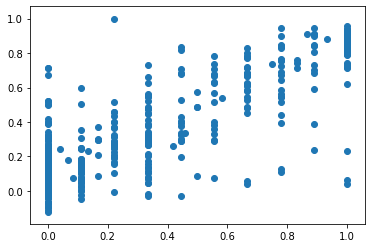

In [25]:
validArr = np.array(validMetrics)
#print(validArr.shape)

test = validArr[1,:,:]
#np.corrcoef(test[1], test[2])

#go through each validation step
for i in range(validArr.shape[0]): 
    subDf = pd.DataFrame(validArr[i].T)
    subDf.columns = ["loss", "pred", "true"]
    corr = np.corrcoef(subDf["pred"], subDf["true"])
    print(corr)
    
plt.scatter(subDf["true"], subDf["pred"])

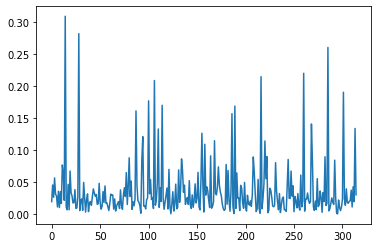

In [26]:
plt.plot(lossList)

In [ ]:
#check memory 
t = torch.cuda.mem_get_info()

used = torch.cuda.memory_allocated(device="cuda:4")
#proportion of free memory 
#print("used: " used / t[1])
print("used: " + str(t[0]/t[1]))

In [ ]:
trainDf = pd.DataFrame.from_dict(trainDict, orient="index")
trainDf.head(3)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=[14,4])
axs[0].plot(trainDf["trainLoss"])
axs[0].set_title("Train Loss", size=14)
axs[0].set_ylabel("MSE Loss",size=14)
axs[0].set_xlabel("batch",size=14)

axs[1].plot(trainDf.dropna()["testLoss"])
axs[1].set_title("Validation Loss",size=14)
axs[1].set_ylabel("MSE Loss",size=14)
axs[1].set_xlabel("batch",size=14)

In [ ]:
print(x)
print(label)
print()

In [ ]:
loss_func(x, label)

In [ ]:
plt.plot(trainDf["testLoss"].dropna())

In [ ]:
valX

In [ ]:
vLabel

In [ ]:
x

In [ ]:
label